**Цель проекта**

Нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку.

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:

- категория A: за ночь — 1 000, разовое обслуживание — 400;

- категория B: за ночь — 800, разовое обслуживание — 350;

- категория C: за ночь — 600, разовое обслуживание — 350;

- категория D: за ночь — 550, разовое обслуживание — 150;

- категория E: за ночь — 500, разовое обслуживание — 150;

- категория F: за ночь — 450, разовое обслуживание — 150;

- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

# Загрузка и обзор данных

Установка и импорт необходимых библиотек



In [ ]:
!pip install optuna
!pip install shap

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, auc, roc_curve, recall_score

sns.set()

Загрузим данные

In [ ]:
data_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Hotel False Booking Detection/hotel_train.csv")
data_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Hotel False Booking Detection/hotel_test.csv")

Данные представляют из себя два файла - hotel_train.csv и hotel_test.csv с обучающей и тестовой выборкой соответственно

In [ ]:
data_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [ ]:
data_train.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


**Описание данных**

В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:

- **id** — номер записи;

- **adults** — количество взрослых постояльцев;

- **arrival_date_year** — год заезда;

- **arrival_date_month** — месяц заезда;

- **arrival_date_week_number** — неделя заезда;

- **arrival_date_day_of_month** — день заезда;

- **babies** — количество младенцев;

- **booking_changes** — количество изменений параметров заказа;

- **children** — количество детей от 3 до 14 лет;

- **country** — гражданство постояльца;

- **customer_type** — тип заказчика:

  - *Contraсt* — договор с юридическим лицом;

  - *Group* — групповой заезд;

  - *Transient* — не связано с договором или групповым заездом;

  - *Transient-party* — не связано с договором или групповым заездом, но связано с бронированием типа Transient.

- **days_in_waiting_list** — сколько дней заказ ожидал подтверждения;

- **distribution_channel** — канал дистрибуции заказа;

- **is_canceled** — отмена заказа;

- **is_repeated_guest** — признак того, что гость бронирует номер второй раз;

- **lead_time** — количество дней между датой бронирования и датой прибытия;

- **meal** — опции заказа:

  - *SC* — нет дополнительных опций;

  - *BB* — включён завтрак;

  - *HB* — включён завтрак и обед;

  - *FB* — включён завтрак, обед и ужин.

- **previous_bookings_not_canceled** — количество подтверждённых заказов у клиента;

- **previous_cancellations** — количество отменённых заказов у клиента;

- **required_car_parking_spaces** — необходимость места для автомобиля;

- **reserved_room_type** — тип забронированной комнаты;

- **stays_in_weekend_nights** — количество ночей в выходные дни;

- **stays_in_week_nights** — количество ночей в будние дни;

- **total_nights** — общее количество ночей;

- **total_of_special_requests** — количество специальных отметок.

# Предобработка и исследовательский анализ данных

Пропусков в данных нет. Проверим есть ли в них дубликаты.

In [ ]:
data_train.duplicated().sum()

0

Дубликаты в данных не обнаружены. Проанализируем каждый столбец.

***id***

Столбец id не влияет на процесс обучения модели, так что удалим его.

In [ ]:
data_train = data_train.drop(columns=["id"],axis=1)

In [ ]:
data_train.duplicated().sum()

21377

После удаления столбца id в данных появились дубликаты. Удалим их.

In [ ]:
data_train = data_train.drop_duplicates(ignore_index=True)

In [ ]:
data_train.duplicated().sum()

0

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43852 entries, 0 to 43851
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     43852 non-null  int64  
 1   lead_time                       43852 non-null  float64
 2   arrival_date_year               43852 non-null  int64  
 3   arrival_date_month              43852 non-null  object 
 4   arrival_date_week_number        43852 non-null  int64  
 5   arrival_date_day_of_month       43852 non-null  int64  
 6   stays_in_weekend_nights         43852 non-null  int64  
 7   stays_in_week_nights            43852 non-null  int64  
 8   adults                          43852 non-null  float64
 9   children                        43852 non-null  float64
 10  babies                          43852 non-null  float64
 11  meal                            43852 non-null  object 
 12  country                         

***is_canceled***

In [ ]:
data_train["is_canceled"].value_counts(normalize=True), data_test["is_canceled"].value_counts(normalize=True)

(0    0.745781
 1    0.254219
 Name: is_canceled, dtype: float64,
 0    0.611533
 1    0.388467
 Name: is_canceled, dtype: float64)

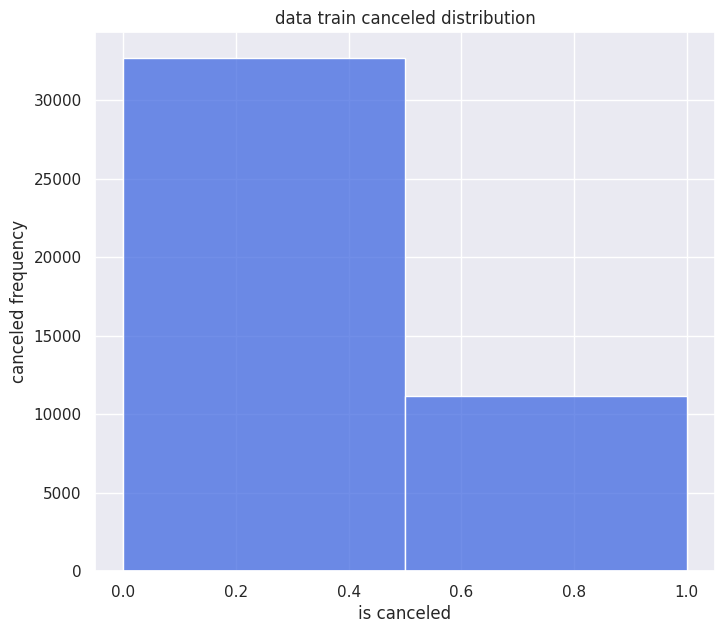

In [ ]:
fig, ax_hist = plt.subplots(sharex=True, figsize=(8, 7))

sns.histplot(x=data_train['is_canceled'], ax=ax_hist, bins=2, color='royalblue')

ax_hist.set(xlabel='is canceled')
ax_hist.set(ylabel='canceled frequency')
ax_hist.set(title='data train canceled distribution')
plt.show()

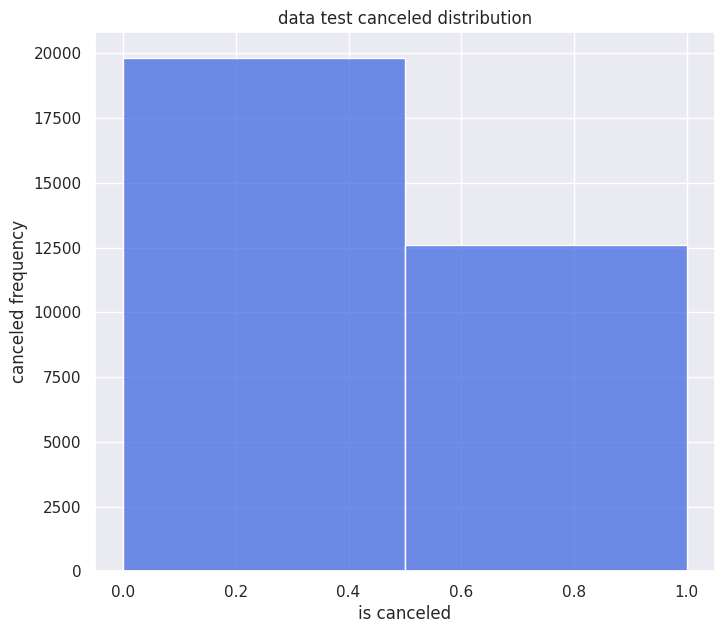

In [ ]:
fig, ax_hist = plt.subplots(sharex=True, figsize=(8, 7))

sns.histplot(x=data_test['is_canceled'], ax=ax_hist, bins=2, color='royalblue')

ax_hist.set(xlabel='is canceled')
ax_hist.set(ylabel='canceled frequency')
ax_hist.set(title='data test canceled distribution')
plt.show()

Столбец имеет распределение Бернулли.

Баланс классов в тестовой и обучающей выборке отличается не сильно.

***lead_time***

Столбец имеет тип число с плавающей точкой, хотя все значения целые. Изменим тип данных на int64.

In [ ]:
data_train['lead_time'] = data_train['lead_time'].astype('int64')

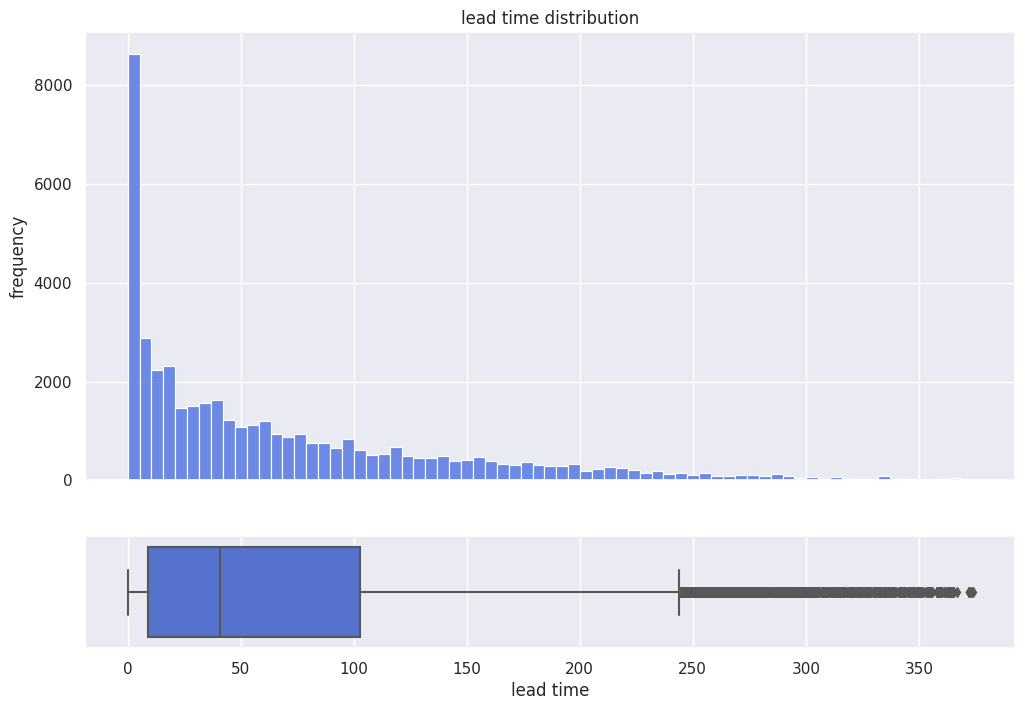

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data_train['lead_time'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data_train['lead_time'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='lead time')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='lead time distribution')
plt.show()

Посмотрим на количество выбросов.

In [ ]:
data_train[data_train['lead_time'] > 200]['lead_time'].count()

3163

Удалим выбросы.

In [ ]:
data_train = data_train[data_train['lead_time'] <= 200]

Распределение экспоненциальное.

***arrival_date_year***

In [ ]:
data_train['arrival_date_year'].unique()

array([2015, 2016])

In [ ]:
data_test['arrival_date_year'].unique()

array([2017])

В обучающей выборке содержатся данные только за 2015 и 2016 год, а в тестовой - только за 2017 год.

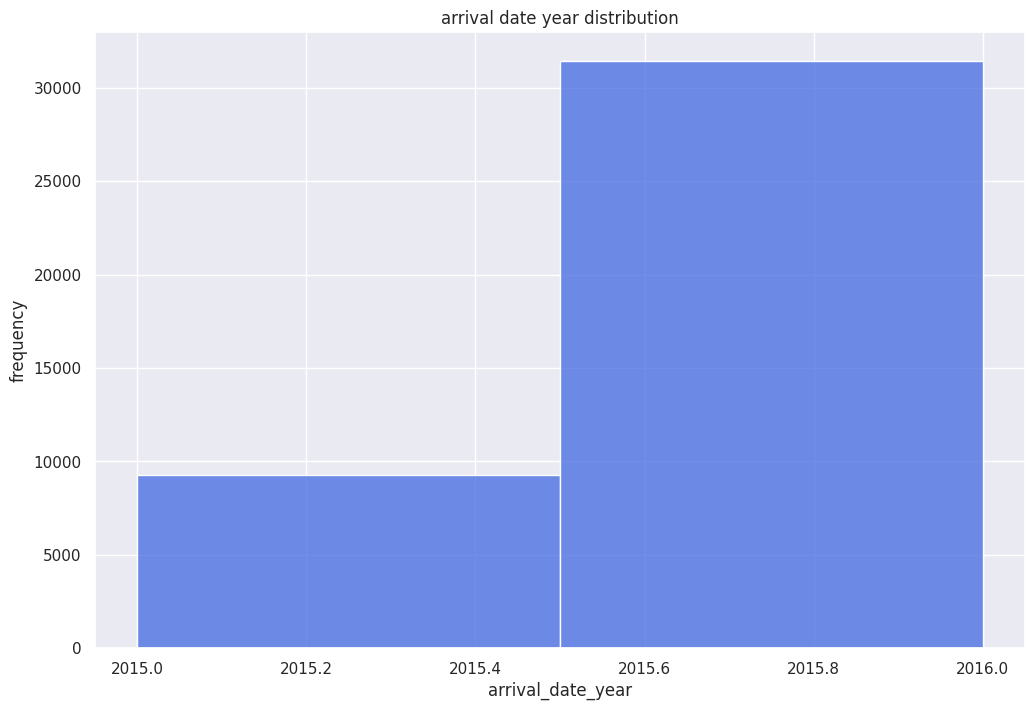

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data_train['arrival_date_year'], ax=ax_hist, bins=2, color='royalblue')

ax_box.set(xlabel='arrival date year')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='arrival date year distribution')
plt.show()

***arrival_date_month***

In [ ]:
data_train['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

Заметим, что в тестовых данных содержатся данные не по всем месяцам, а только от начала года до осени

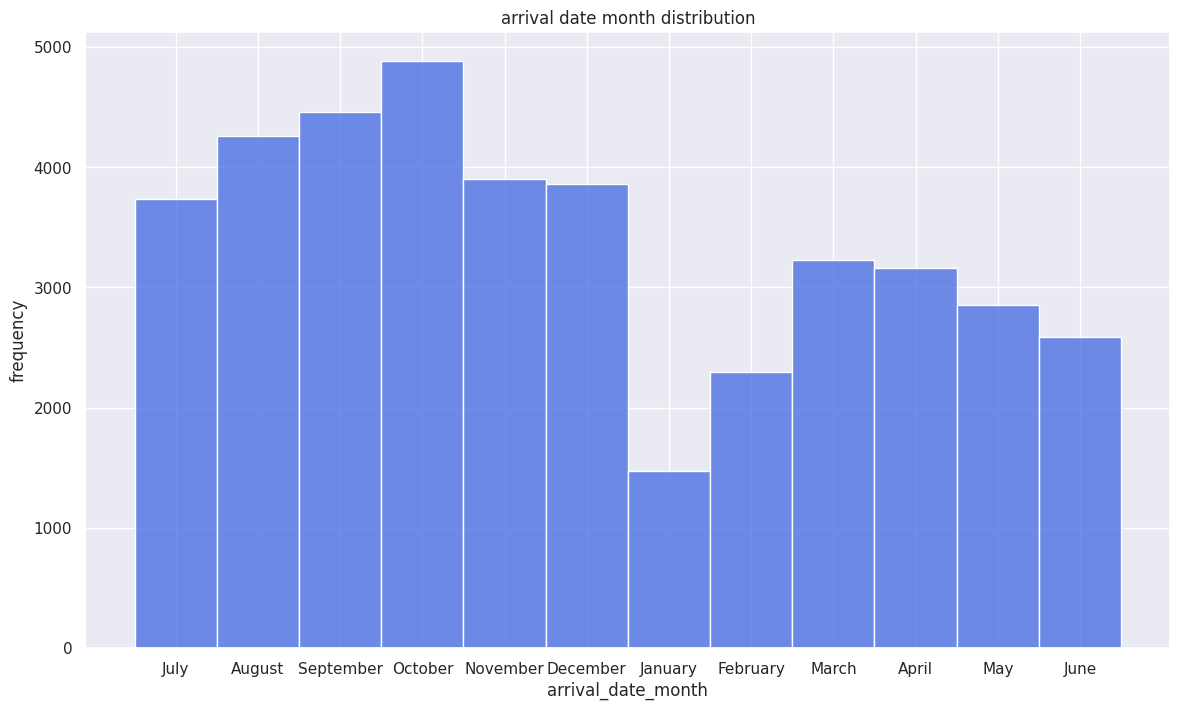

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(14, 8))

sns.histplot(x=data_train['arrival_date_month'], ax=ax_hist, bins=12, color='royalblue')

ax_box.set(xlabel='arrival date month')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='arrival date month distribution')
plt.show()

Распределение данных нормальное.

***arrival_date_week_number***

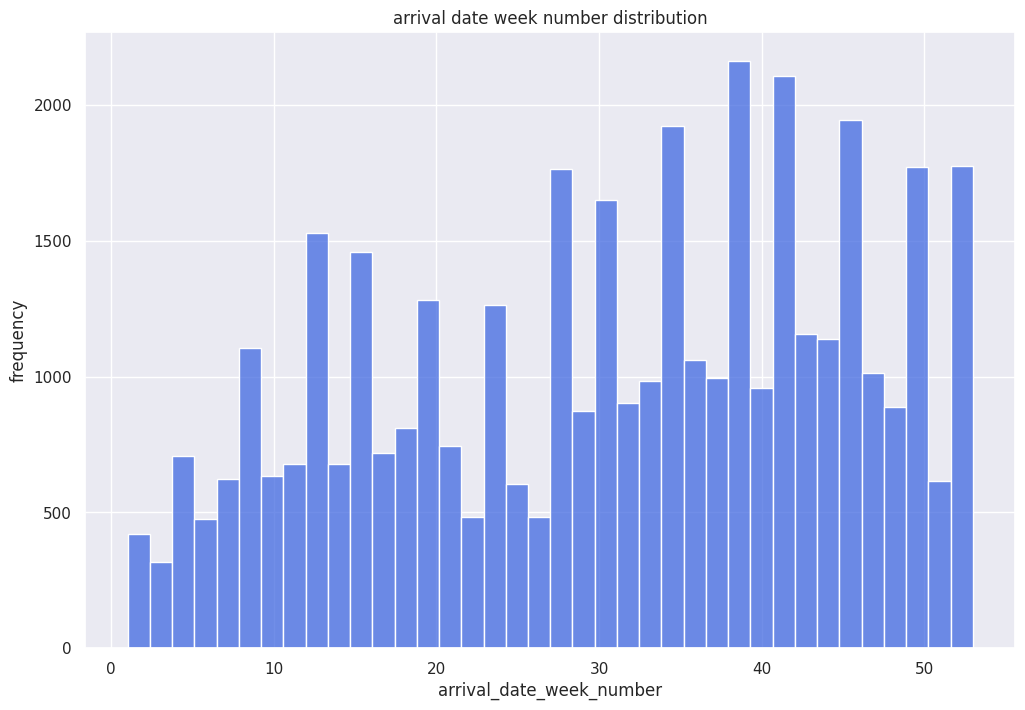

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data_train['arrival_date_week_number'], ax=ax_hist, color='royalblue')

ax_box.set(xlabel='arrival date week number')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='arrival date week number distribution')
plt.show()

Тестовые данные столбца представлены не по всем неделям, а только по первым 35.

Распределение нормальное.

***arrival_date_day_of_month***

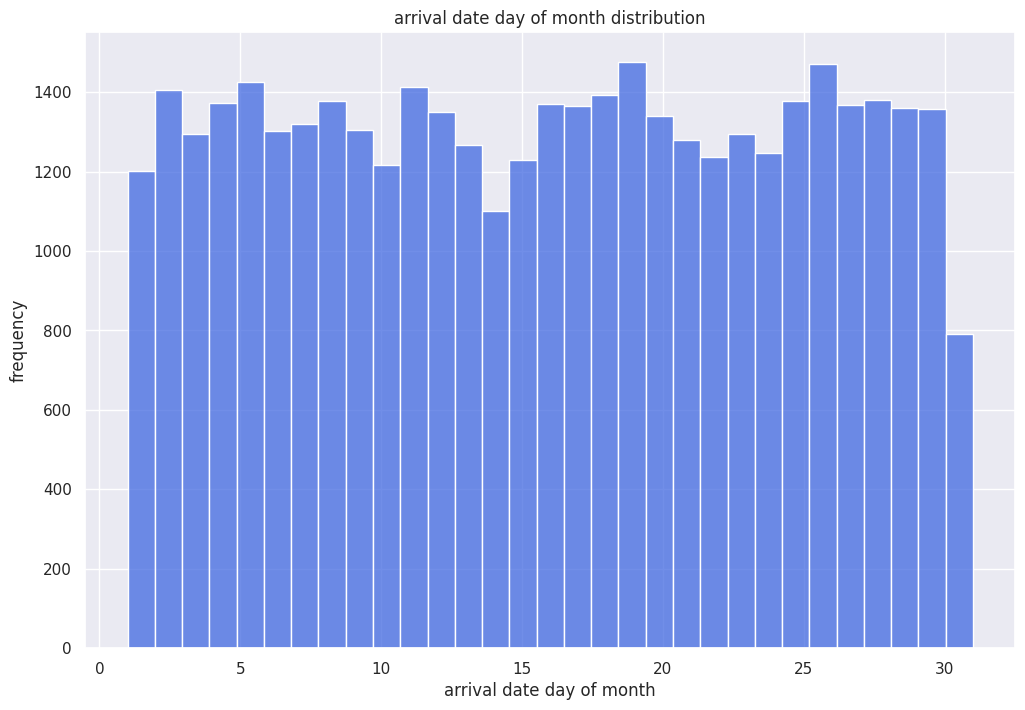

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data_train['arrival_date_day_of_month'], ax=ax_hist, bins=31, color='royalblue')

ax_hist.set(xlabel='arrival date day of month')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='arrival date day of month distribution')
plt.show()

Распределение данных близко к равномерному

***stays_in_weekend_nights***

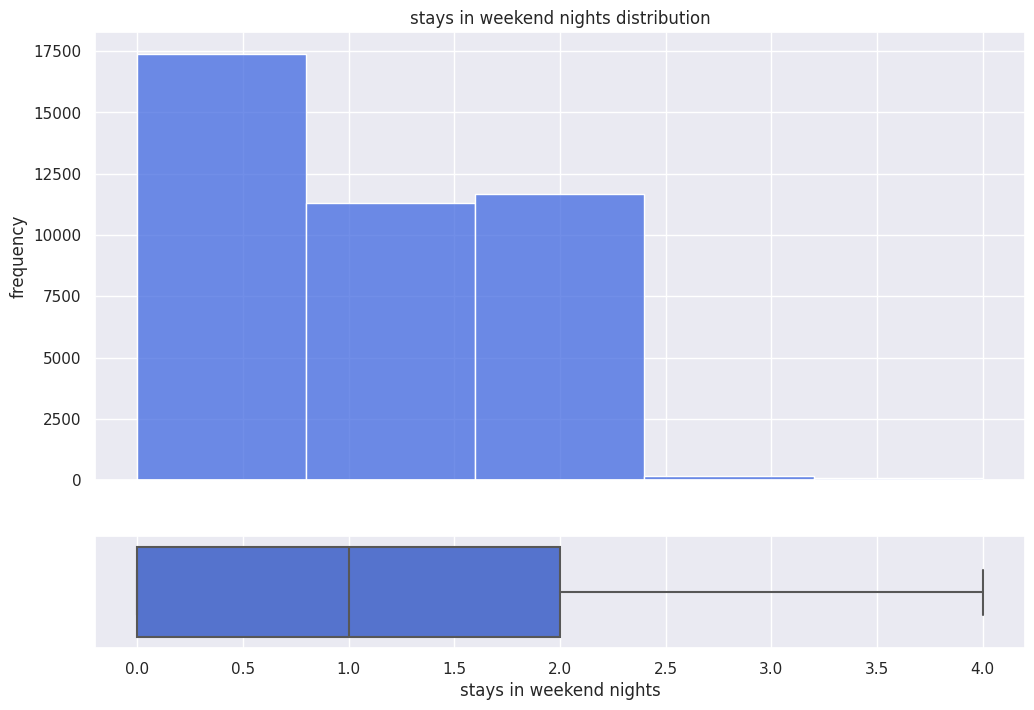

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data_train['stays_in_weekend_nights'], ax=ax_hist, bins=5, color='royalblue')
sns.boxplot(x=data_train['stays_in_weekend_nights'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='stays in weekend nights')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='stays in weekend nights distribution')
plt.show()

Распределение данных близко к экспоненциальному

***stays_in_week_nights***

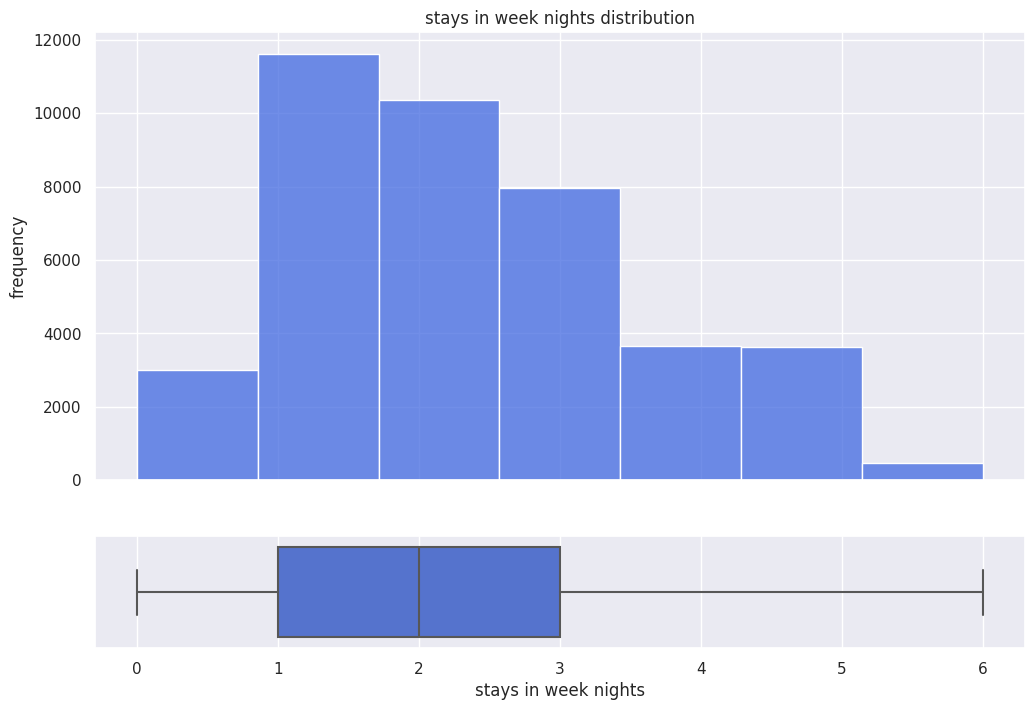

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data_train['stays_in_week_nights'], ax=ax_hist, bins=7, color='royalblue')
sns.boxplot(x=data_train['stays_in_week_nights'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='stays in week nights')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='stays in week nights distribution')
plt.show()

Данные распределены логнормально

***adults***

Количество взрослых представлено в формате чисел с плавающей точкой. Изменим тип на целочисленный.

In [ ]:
data_train['adults'] = data_train['adults'].astype('int64')

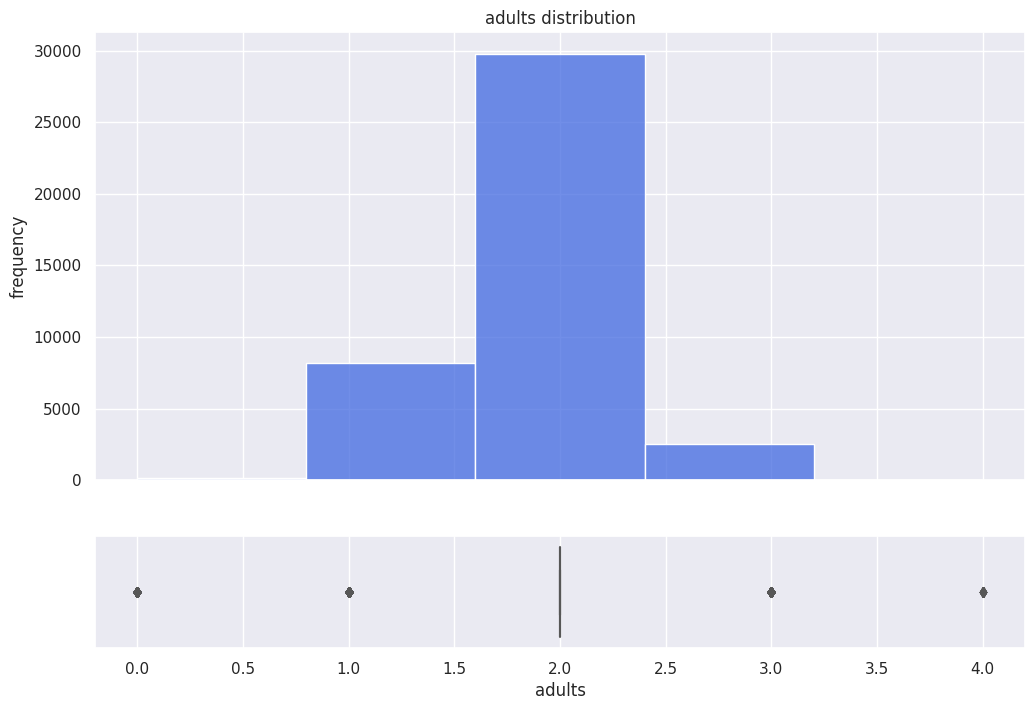

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data_train['adults'], ax=ax_hist, bins=5, color='royalblue')
sns.boxplot(x=data_train['adults'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='adults')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='adults distribution')
plt.show()

Данные распределены нормально.

***children***

Тип переменной количества детей изменим на целочисленный.

In [ ]:
data_train['children'] = data_train['children'].astype('int64')

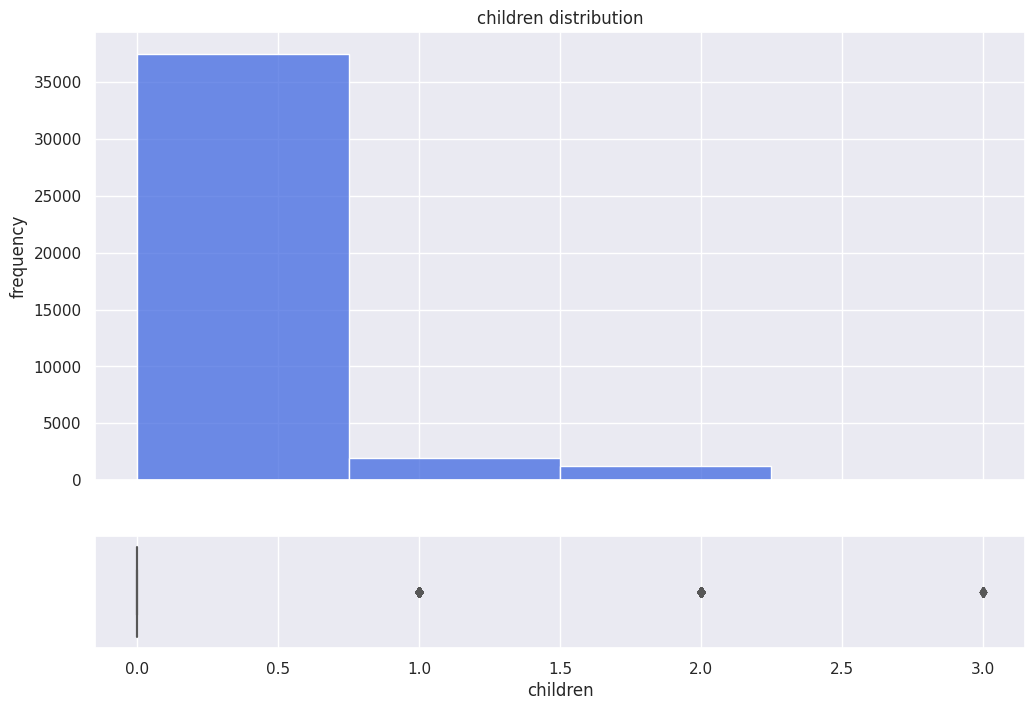

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data_train['children'], ax=ax_hist, bins=4, color='royalblue')
sns.boxplot(x=data_train['children'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='children')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='children distribution')
plt.show()

Распределение данных экспоненциальное.

***babies***

Поменяем тип данных на целочисленный.

In [ ]:
data_train['babies'] = data_train['babies'].astype('int64')

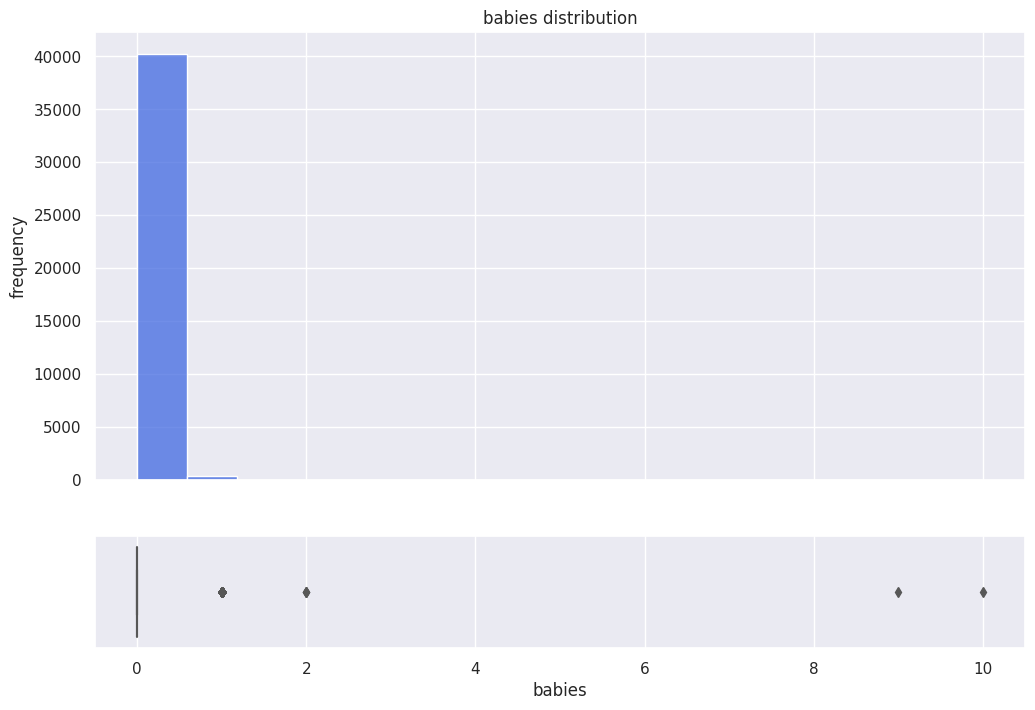

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data_train['babies'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data_train['babies'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='babies')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='babies distribution')
plt.show()

In [ ]:
data_train[data_train['babies'] >= 9]['babies'].count()

2

В обучающей есть очень малое количество выбросов, можно их удалить.

In [ ]:
data_train = data_train[data_train['babies'] < 9]

Распределение данных экспоненциальное.

***meal***

In [ ]:
data_train['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

Удалим пробелы в значениях столбца.

In [ ]:
data_train['meal'] = data_train['meal'].str.strip()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
data_train['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

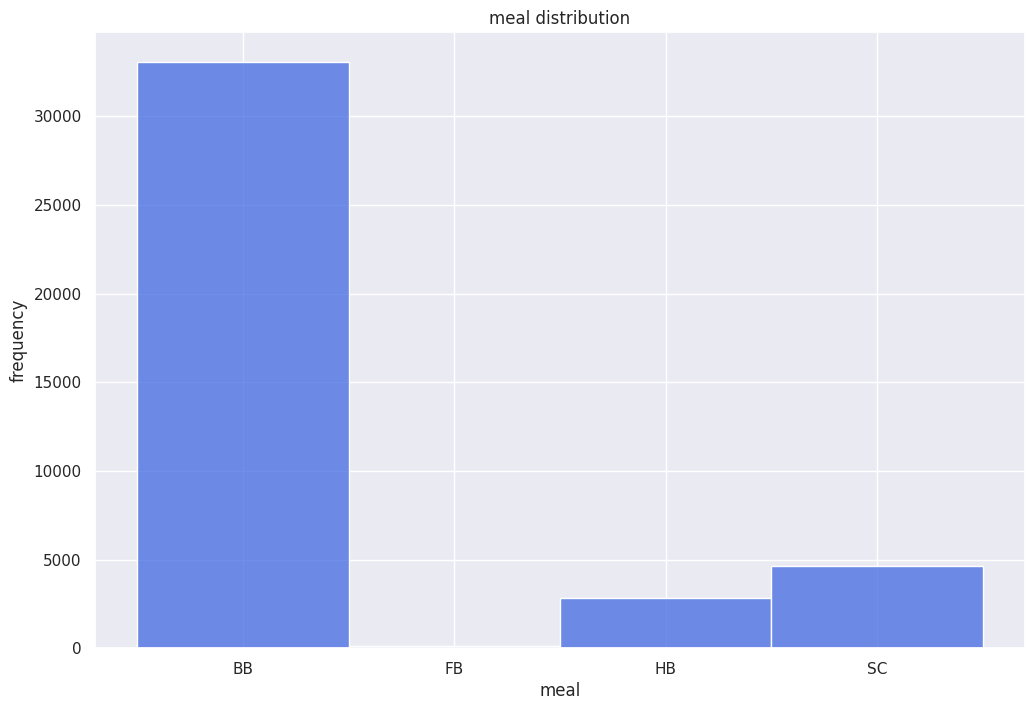

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data_train['meal'], ax=ax_hist, color='royalblue')

ax_hist.set(xlabel='meal')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='meal distribution')
plt.show()

Данные распределение экспоненциально.

***country***

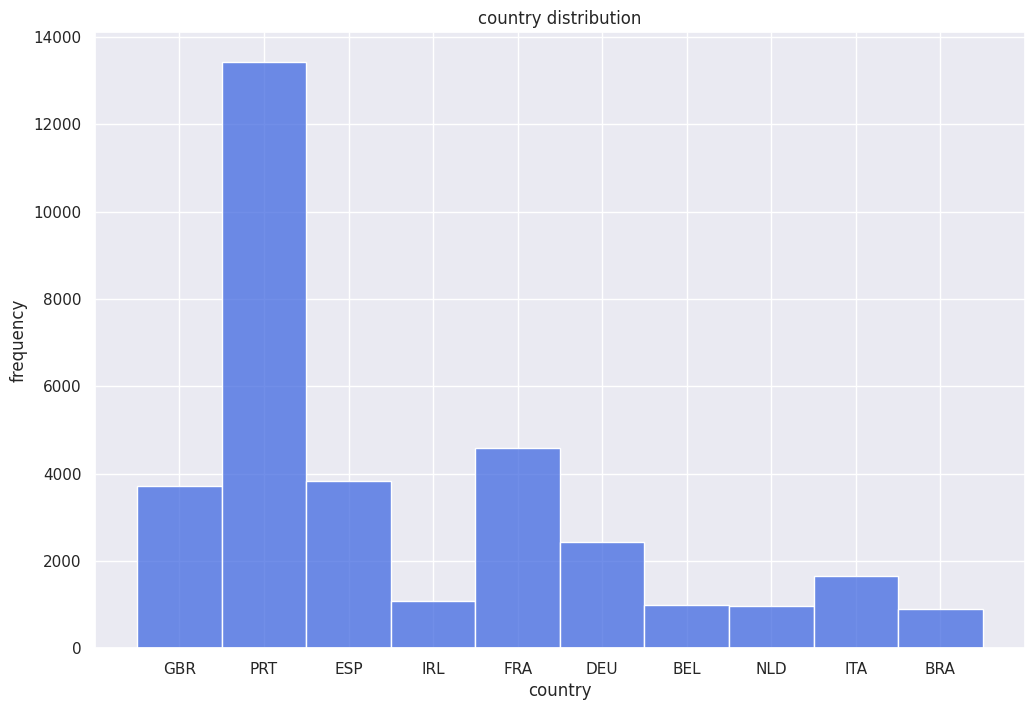

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data_train[data_train["country"].isin(data_train['country'].value_counts()[:10].index)]['country'], ax=ax_hist, color='royalblue')

ax_hist.set(xlabel='country')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='country distribution')
plt.show()

Данные распределены экспоненциально.

***distribution_channel***

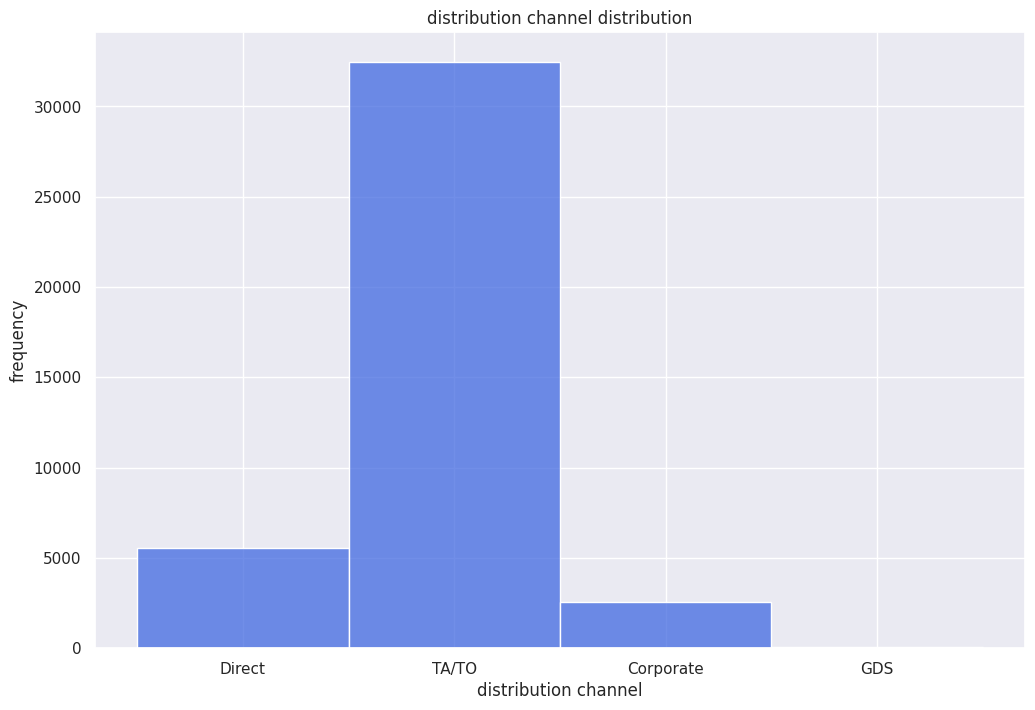

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data_train['distribution_channel'], ax=ax_hist, color='royalblue')

ax_hist.set(xlabel='distribution channel')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='distribution channel distribution')
plt.show()

Распределение данных нормально.

***is_repeated_guest***

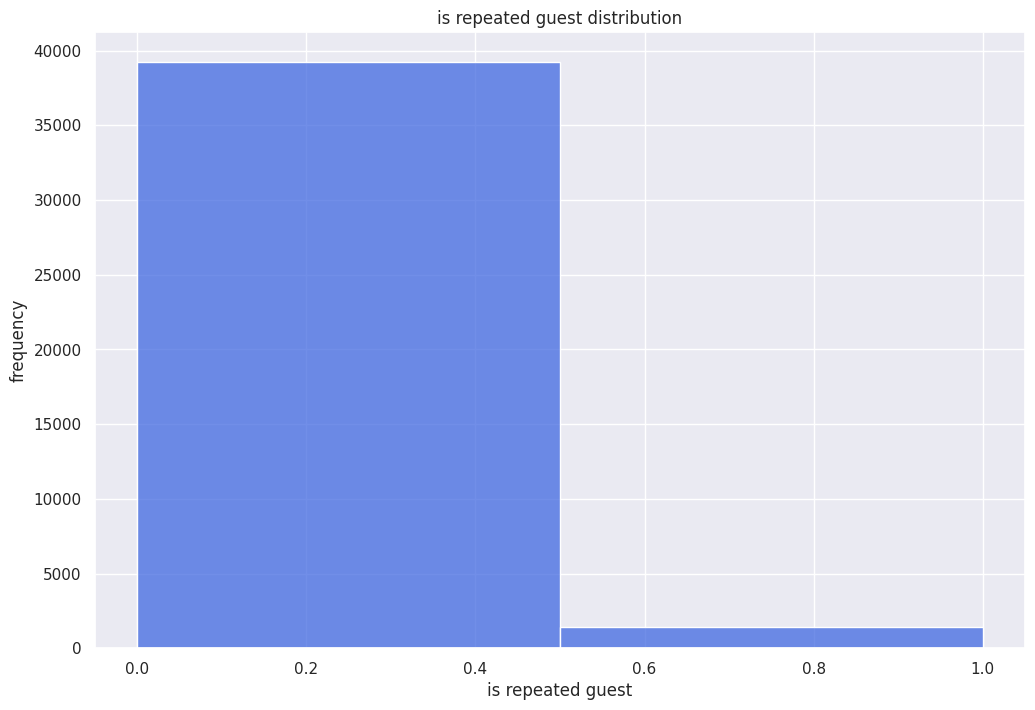

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data_train['is_repeated_guest'], ax=ax_hist, bins=2,color='royalblue')

ax_hist.set(xlabel='is repeated guest')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='is repeated guest distribution')
plt.show()

Данные имеют распределение Бернулли.

***previous_cancellations***

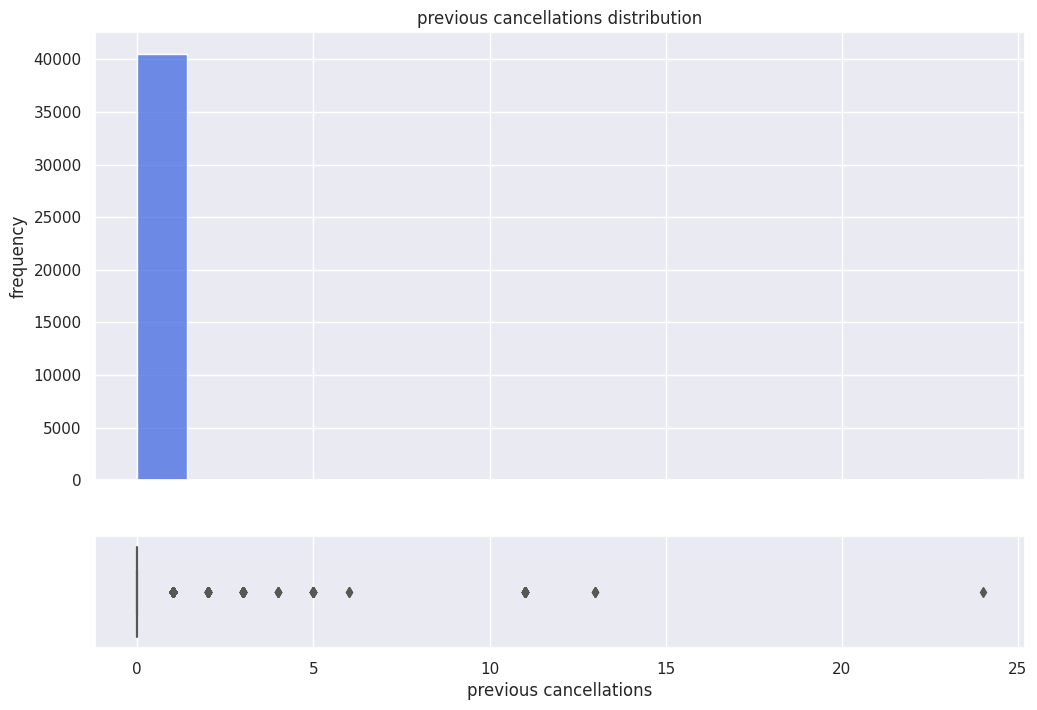

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data_train['previous_cancellations'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data_train['previous_cancellations'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='previous cancellations')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='previous cancellations distribution')
plt.show()

In [ ]:
data_train[data_train['previous_cancellations'] > 6]['previous_cancellations'].count()

31

В обучающих данных есть небольшое количество выбросов, уберем их.

In [ ]:
data_train = data_train[data_train['previous_cancellations'] <= 6]

Распределение данных близко к экспоненциальному.

***previous_bookings_not_canceled***

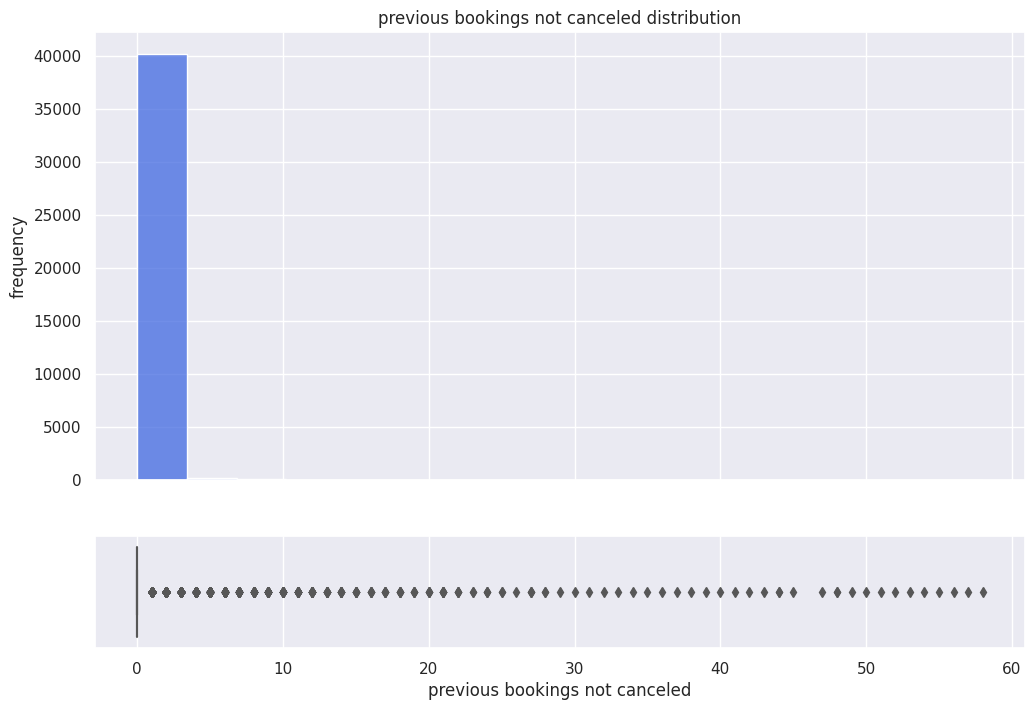

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data_train['previous_bookings_not_canceled'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data_train['previous_bookings_not_canceled'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='previous bookings not canceled')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='previous bookings not canceled distribution')
plt.show()

In [ ]:
data_train[data_train['previous_bookings_not_canceled'] >= 30]['previous_bookings_not_canceled'].count()

30

Удалим выбросы.

In [ ]:
data_train = data_train[data_train['previous_bookings_not_canceled'] <= 30]

Данные распределены экспоненциально.

***reserved_room_type***

In [ ]:
data_train['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [ ]:
data_train['reserved_room_type'] = data_train['reserved_room_type'].str.strip()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Удалим пробелы в значениях столбца

In [ ]:
data_train['reserved_room_type'].unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

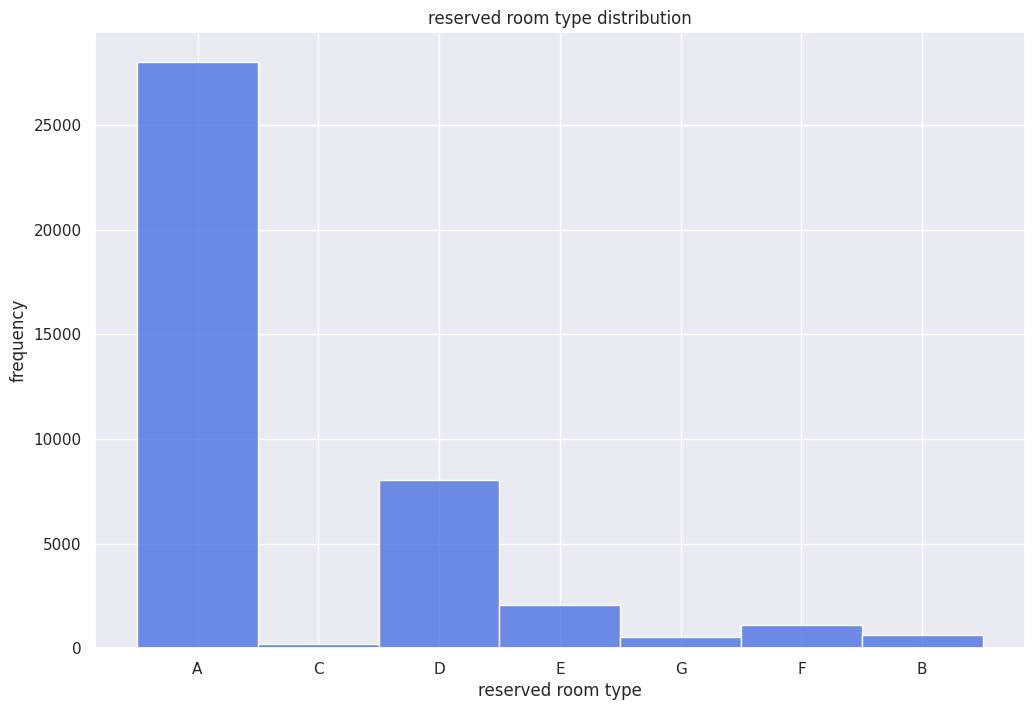

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data_train['reserved_room_type'], ax=ax_hist, color='royalblue')

ax_hist.set(xlabel='reserved room type')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='reserved room type distribution')
plt.show()

Распределение близко к экспоненциальному.

***booking_changes***

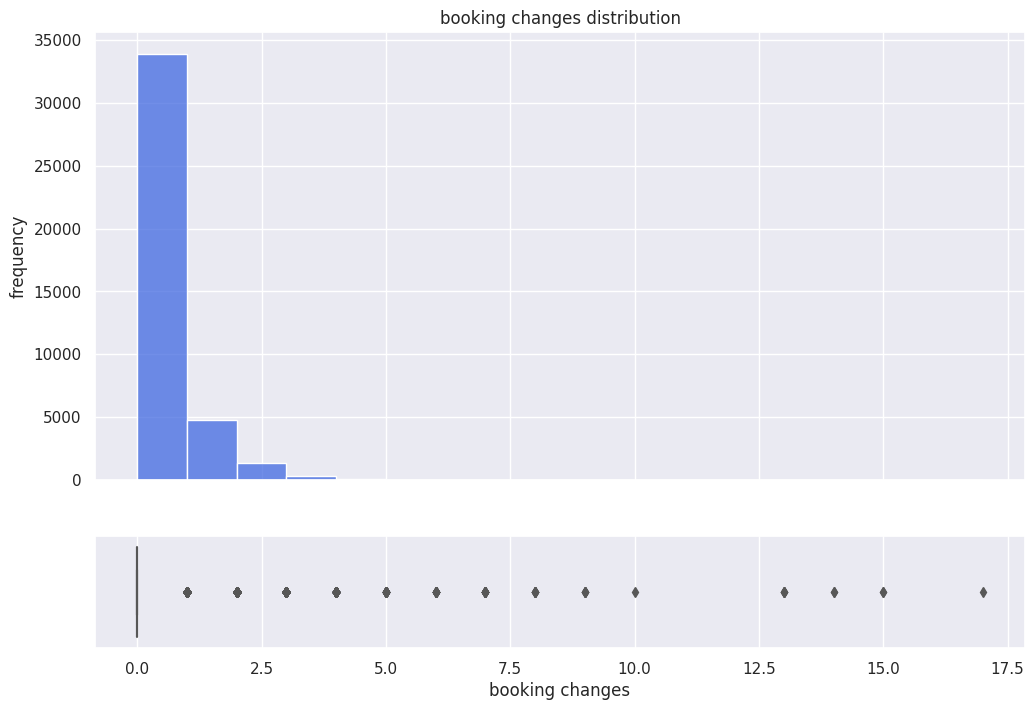

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data_train['booking_changes'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data_train['booking_changes'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='booking changes')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='booking changes distribution')
plt.show()

Данные распределены экспоненциально.

***days_in_waiting_list***

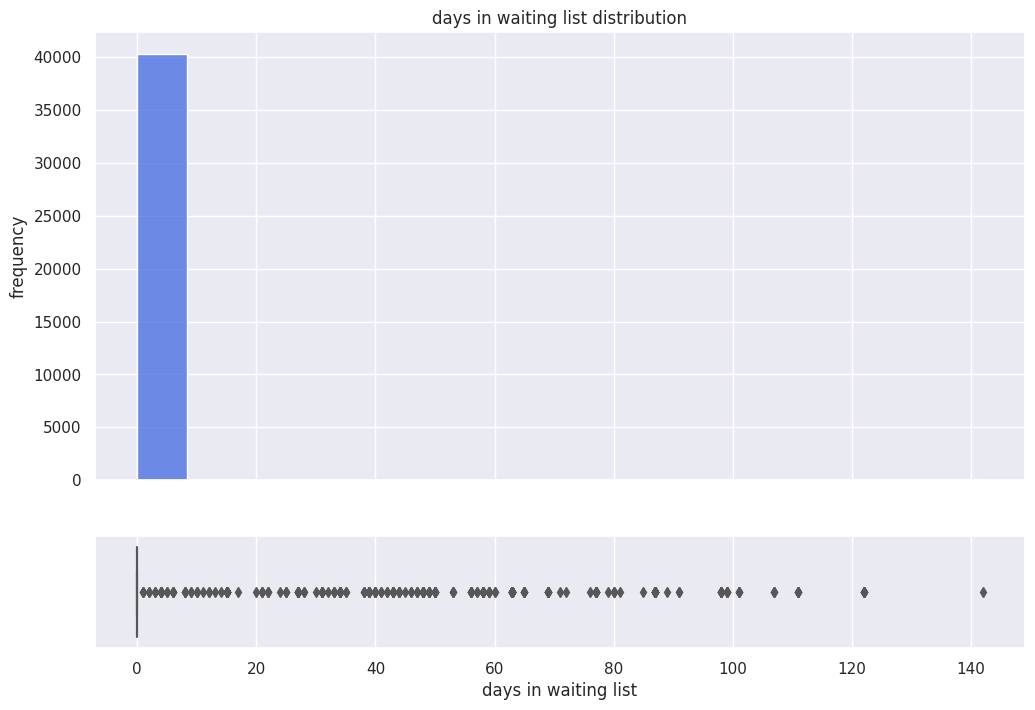

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data_train['days_in_waiting_list'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data_train['days_in_waiting_list'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='days in waiting list')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='days in waiting list distribution')
plt.show()

In [ ]:
data_train[data_train['days_in_waiting_list'] > 5]['days_in_waiting_list'].count()

295

Удалим выбросы.

In [ ]:
data_train = data_train[data_train['days_in_waiting_list'] <= 5]

Данные распределены экспоненциально.

***customer_type***

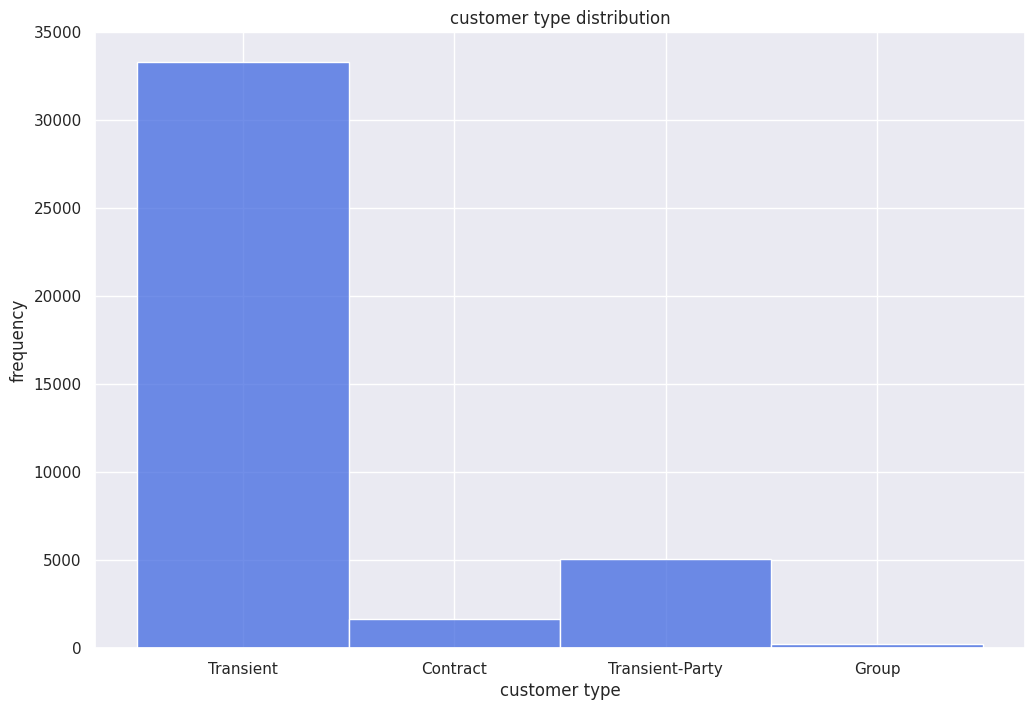

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data_train['customer_type'], ax=ax_hist, color='royalblue')

ax_hist.set(xlabel='customer type')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='customer type distribution')
plt.show()

Данные распределены нормально.

***required_car_parking_spaces***

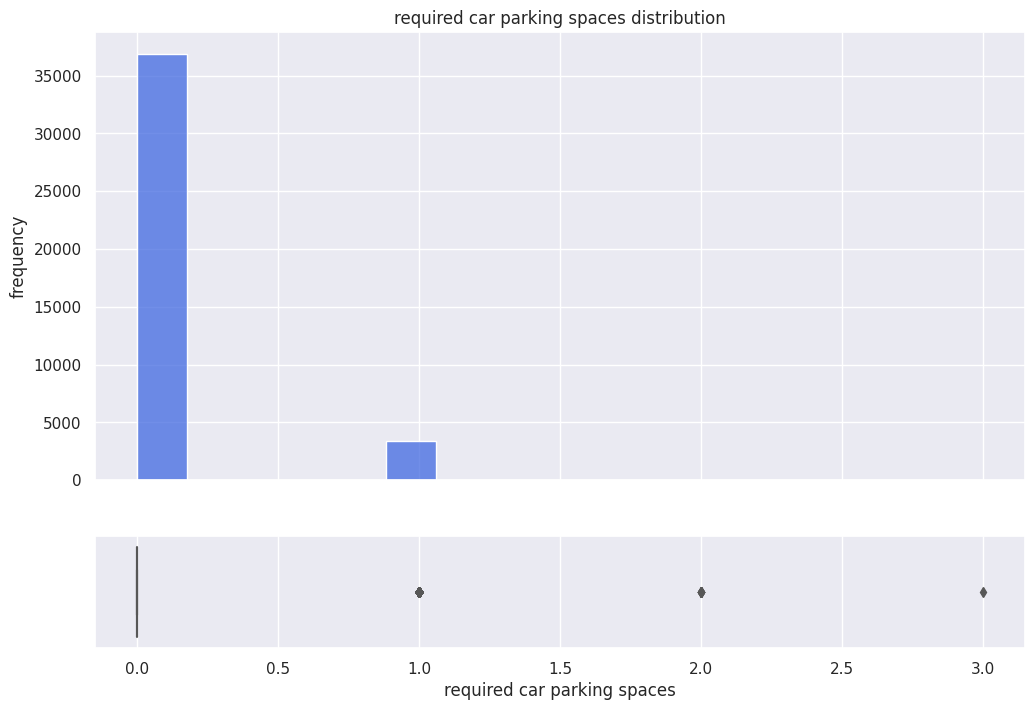

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data_train['required_car_parking_spaces'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data_train['required_car_parking_spaces'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='required car parking spaces')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='required car parking spaces distribution')
plt.show()

Данные распределены экспоненциально.

***total_of_special_requests***

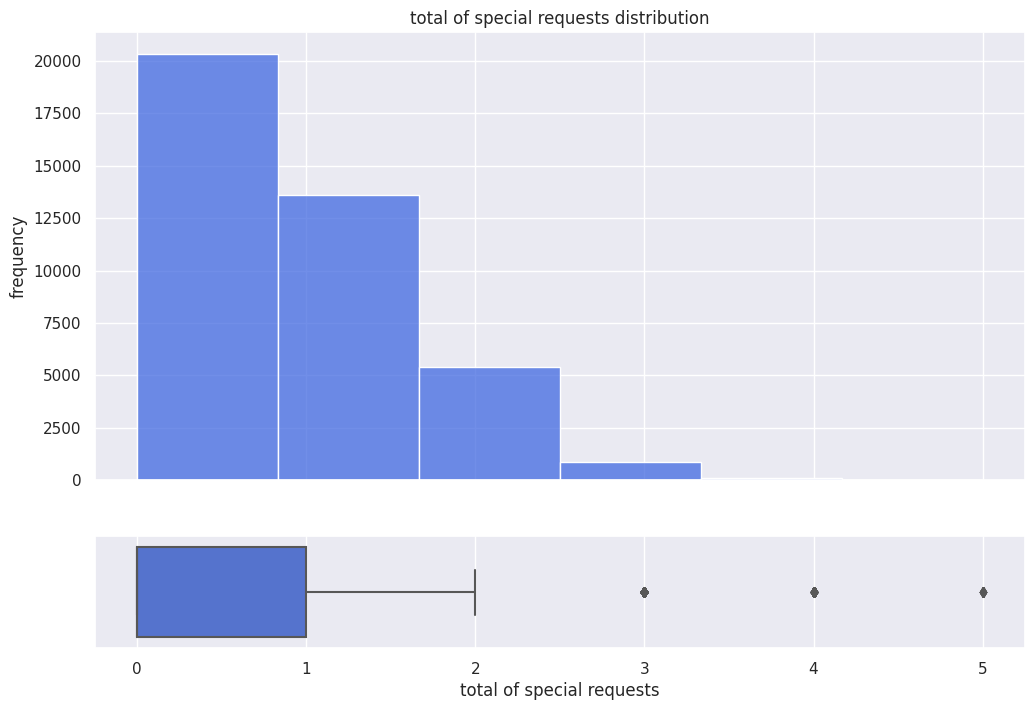

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data_train['total_of_special_requests'], ax=ax_hist, bins=6, color='royalblue')
sns.boxplot(x=data_train['total_of_special_requests'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='total of special requests')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='total of special requests distribution')
plt.show()

Данные распределены экспоненциально.

In [ ]:
data_train[data_train['total_of_special_requests'] > 3]['total_of_special_requests'].count()

98

Значения больше 3 можно удалить, так как их немного.

In [ ]:
data_train = data_train[data_train['total_of_special_requests'] <= 3]

***total_nights***

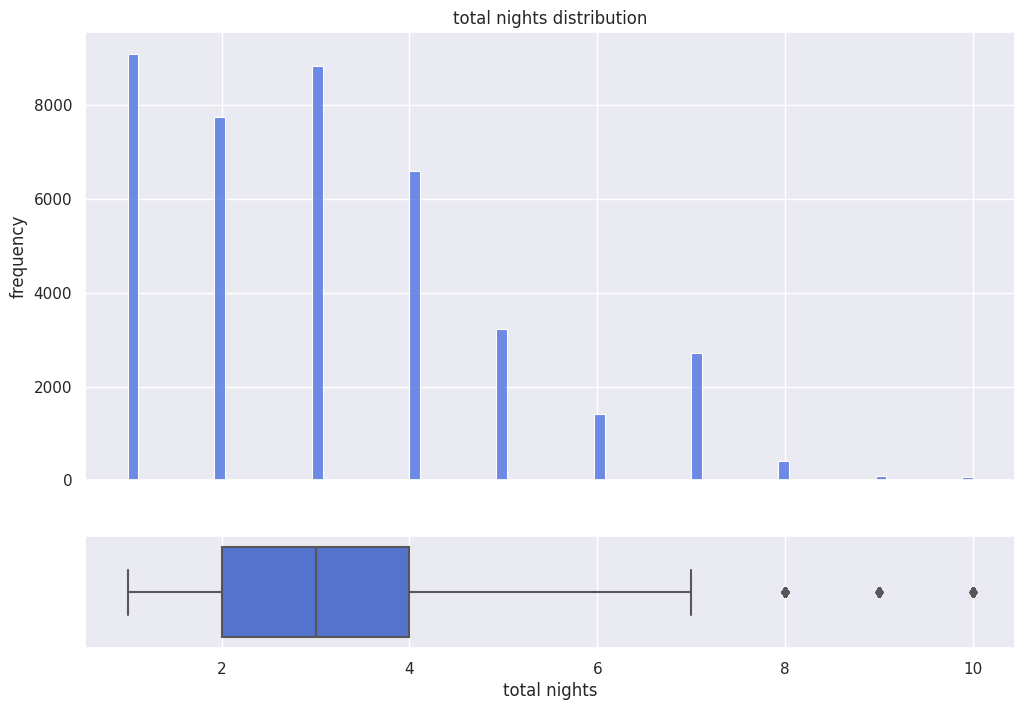

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data_train['total_nights'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data_train['total_nights'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='total nights')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='total nights distribution')
plt.show()

Данные распределны логнормально.

In [ ]:
data_train[data_train['total_nights'] > 7]['total_nights'].count()

583

Выбросов немного, их можно удалить.

In [ ]:
data_train = data_train[data_train['total_nights'] <= 7].reset_index()

In [ ]:
data_train = data_train.drop(columns=['index'])

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39651 entries, 0 to 39650
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   is_canceled                     39651 non-null  int64 
 1   lead_time                       39651 non-null  int64 
 2   arrival_date_year               39651 non-null  int64 
 3   arrival_date_month              39651 non-null  object
 4   arrival_date_week_number        39651 non-null  int64 
 5   arrival_date_day_of_month       39651 non-null  int64 
 6   stays_in_weekend_nights         39651 non-null  int64 
 7   stays_in_week_nights            39651 non-null  int64 
 8   adults                          39651 non-null  int64 
 9   children                        39651 non-null  int64 
 10  babies                          39651 non-null  int64 
 11  meal                            39651 non-null  object
 12  country                         39651 non-null

Напишем функцию для преобразования тестовых данных к пригодным для обучения виду.

In [ ]:
def preprocess(df):
  df = df.drop(columns=['id'], axis=1)
  df['lead_time'] = df['lead_time'].astype('int64')
  df['adults'] = df['adults'].astype('int64')
  df['children'] = df['children'].astype('int64')
  df['babies'] = df['babies'].astype('int64')
  df['meal'] = df['meal'].str.strip()
  df['reserved_room_type'] = df['reserved_room_type'].str.strip()
  return df

In [ ]:
data_test = preprocess(data_test)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

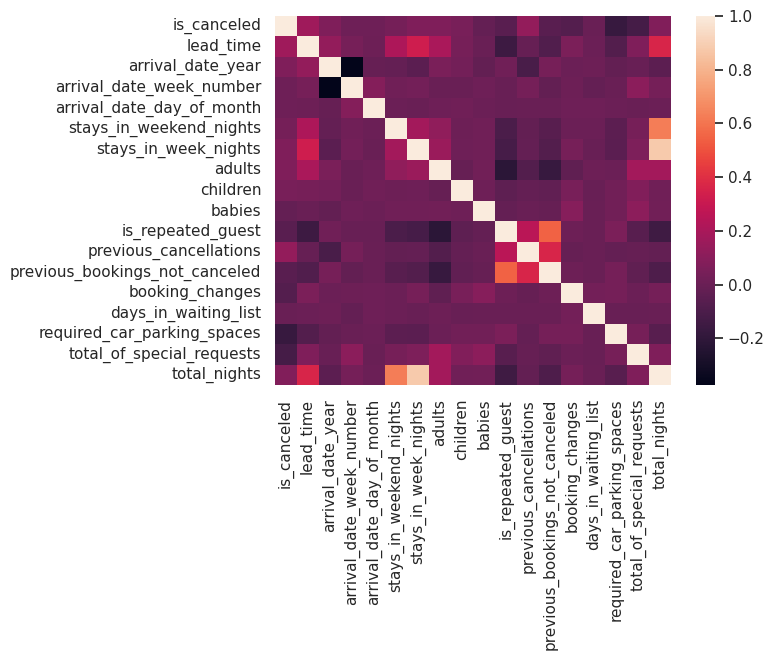

In [ ]:
sns.heatmap(data_train.corr())

# Вычисление бизнес-метрики



Рассчитаем прибыль без внедрения депозитов.

In [ ]:
def profit_calc(row):
  nights = row['total_nights']
  room_type = row['reserved_room_type']
  month = row['arrival_date_month']
  is_canceled = row['is_canceled']
  num_of_servicing = (nights + 1) // 2
  room_fare = {'A': [1000, 400], 'B': [800, 350], 'C': [600, 350], 'D': [550, 150], 'E': [500, 150], 'F': [450, 150], 'G': [350, 150]}
  multiplier = {'March': 1.2, 'April': 1.2, 'May': 1.2, 'September': 1.2, 'October': 1.2, 'November': 1.2, 'June': 1.4, 'July': 1.4, 'August': 1.4, 'December': 1, 'January': 1, 'February': 1}
  if is_canceled == 0:
    return room_fare[room_type][0] * nights * multiplier[month] - room_fare[room_type][1] * num_of_servicing
  else:
    return - (room_fare[room_type][0] * multiplier[month] + room_fare[room_type][1])

In [ ]:
profit_train = data_train.apply(profit_calc, axis=1)
profit_test = data_test.apply(profit_calc, axis=1)

Рассчитали прибыль от каждой брони. Теперь просуммируем их, чтобы узнать общую прибыль.

In [ ]:
profit_train.sum() + profit_test.sum()

97151970.0

Прибыль по всем строкам равна почти 97 миллионов 152 тысяч рублей.

# Разработка моделей

Данная задача предполагает, что для бизнес-метрики критично, когда модель выдает ложноотрицательный вывод, то есть происходит ошибка второго рода. В связи с этим за ML-метрику следует взять recall. Реализуем два подхода обучения:

1) С использованием метрики auc-roc;

2) С использованием метрики Recall.

Для начала разработаем и обучим модель логистической регрессии для бинарной классификации.

Для обучения модели не пригодятся столбцы с датами. Удалим их.

In [ ]:
x_train = data_train.drop(columns=['is_canceled', 'arrival_date_year', 'arrival_date_week_number'], axis=1)
y_train = data_train['is_canceled']

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=987, stratify=y_train)

x_test = data_test.drop(columns=['is_canceled', 'arrival_date_year', 'arrival_date_week_number'], axis=1)
y_test = data_test['is_canceled']

In [ ]:
x_train.shape, x_valid.shape, x_test.shape

((29738, 21), (9913, 21), (32412, 21))

In [ ]:
y_train.shape, y_valid.shape, y_test.shape

((29738,), (9913,), (32412,))

Применим One Hot Encoding.


In [ ]:
x_train_len = len(x_train)
x_valid_len = x_train_len + len(x_valid)
x_all = pd.concat([pd.concat([x_train, x_valid]), x_test])
x_all_ohe = pd.get_dummies(x_all, drop_first = True)
x_train_ohe = x_all_ohe.iloc[:x_train_len,:]
x_valid_ohe = x_all_ohe.iloc[x_train_len:x_valid_len,:]
x_test_ohe = x_all_ohe.iloc[x_valid_len:,:]

In [ ]:
x_train_ohe.shape, x_valid_ohe.shape, x_test_ohe.shape

((29738, 212), (9913, 212), (32412, 212))

**Логистическая регрессия**

In [ ]:
def objective(trial):
  params = {"max_iter": trial.suggest_int("max_iter", 100, 1500)
            }
  model = LogisticRegression(**params, solver='liblinear', class_weight='balanced', random_state=987)
  model.fit(x_train_ohe, y_train)
  predicted_valid = model.predict(x_valid_ohe)
  return roc_auc_score(y_valid, predicted_valid)

In [ ]:
sampler = optuna.samplers.TPESampler(seed=987)
study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=25)

[I 2023-10-06 12:47:54,818] A new study created in memory with name: no-name-96e680d2-e897-4444-bc15-355ba304abdc


In [ ]:
print('best params:', study.best_params)

best params: {'max_iter': 668}


In [ ]:
best_model = LogisticRegression(**study.best_params, class_weight='balanced', solver='liblinear', random_state=987)

In [ ]:
best_model.fit(x_train_ohe, y_train)

LogisticRegression(class_weight='balanced', max_iter=668, random_state=987,
                   solver='liblinear')

In [ ]:
cross_val_roc_auc = cross_val_score(best_model, x_valid_ohe, y_valid, cv=5, scoring='roc_auc')
print("cross-validation auc-roc score:", sum(cross_val_roc_auc) / len(cross_val_roc_auc))

cross-validation auc-roc score: 0.790550818566443


**Дерево решений.**

In [ ]:
x_train_len = len(x_train)
x_valid_len = x_train_len + len(x_valid)
x_all = pd.concat([pd.concat([x_train, x_valid]), x_test])
encoder = OrdinalEncoder()
encoder.fit(x_all)
x_all = pd.DataFrame(encoder.transform(x_all), columns=x_all.columns)
x_train = x_all.iloc[:x_train_len, :]
x_valid = x_all.iloc[x_train_len:x_valid_len, :]
x_test = x_all.iloc[x_valid_len:, :]

In [ ]:
def objective(trial):
  params = {"max_depth": trial.suggest_int("max_depth", 6, 20),
             'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
             'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
             'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
             'splitter': trial.suggest_categorical('splitter', ['best', 'random'])
            }
  model = DecisionTreeClassifier(**params, class_weight='balanced', random_state=987)
  model.fit(x_train, y_train)
  predicted_valid = model.predict(x_valid)
  return roc_auc_score(y_valid, predicted_valid)

In [ ]:
sampler = optuna.samplers.TPESampler(seed=987)
study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=30)

In [ ]:
print('best params:', study.best_params)

best params: {'max_depth': 18, 'min_samples_leaf': 10, 'min_samples_split': 8, 'criterion': 'log_loss', 'splitter': 'random'}


In [ ]:
best_model = DecisionTreeClassifier(**study.best_params, class_weight='balanced', random_state=987)

In [ ]:
best_model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=18, min_samples_leaf=10, min_samples_split=8,
                       random_state=987, splitter='random')

In [ ]:
cross_val_roc_auc = cross_val_score(best_model, x_valid, y_valid, cv=5, scoring='roc_auc')
print("cross-validation auc-roc score:", sum(cross_val_roc_auc) / len(cross_val_roc_auc))

cross-validation auc-roc score: 0.7528153109809599


По сравнению с моделью логистической регрессии метрика немного ухудшились.


**Случайный лес.**

In [ ]:
def objective(trial):
  params = {"max_depth": trial.suggest_int("max_depth", 6, 20),
             'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
             'n_estimators': trial.suggest_int('n_estimators', 10, 1600, log=True),
             'min_samples_split': trial.suggest_int('min_samples_split', 2, 10)
            }
  model = RandomForestClassifier(**params, class_weight='balanced', random_state=987)
  model.fit(x_train, y_train)
  predicted_valid = model.predict(x_valid)
  return roc_auc_score(y_valid, predicted_valid)

In [ ]:
sampler = optuna.samplers.TPESampler(seed=987)
study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=30)

In [ ]:
print('best params:', study.best_params)

best params: {'max_depth': 20, 'min_samples_leaf': 7, 'n_estimators': 23, 'min_samples_split': 6}


In [ ]:
best_model = RandomForestClassifier(**study.best_params, class_weight='balanced', random_state=987)

In [ ]:
best_model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=7, min_samples_split=6, n_estimators=23,
                       random_state=987)

In [ ]:
cross_val_roc_auc = cross_val_score(best_model, x_valid, y_valid, cv=5, scoring='roc_auc')
print("cross-validation auc-roc score:", sum(cross_val_roc_auc) / len(cross_val_roc_auc))

cross-validation auc-roc score: 0.8113866817025983


Обучение модели случайного леса заняло намного больше времени. Но она показала наилучшие результаты.

auc-roc = 0.81, прирост на 0.04.

Проверим работу наилучшей модели на тестовых данных.

In [ ]:
pred = best_model.predict(x_test)

auc_roc = roc_auc_score(y_test, best_model.predict_proba(x_test)[:, 1])
print("AUC-ROC score:", auc_roc)

AUC-ROC score: 0.8257788411108264


При проверке модели на тестовой выборке модель показала себя почти так же.

auc-roc = 0.825

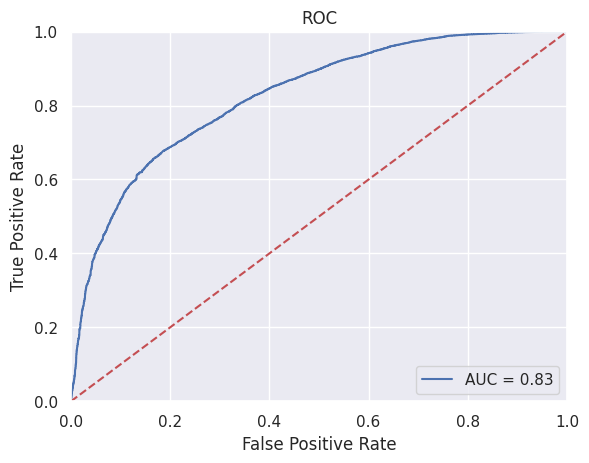

In [ ]:
probs = best_model.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Расчет прибыли после внедрения модели**

Напишем функцию рассчета прибыли за год с внедрением модели.

In [ ]:
data_test['pred'] = pd.Series(pred)

In [ ]:
def profit_calc_ml(row):
  nights = row['total_nights']
  room_type = row['reserved_room_type']
  month = row['arrival_date_month']
  is_canceled = row['is_canceled']
  pred = row['pred']
  num_of_servicing = (nights + 1) // 2
  room_fare = {'A': [1000, 400], 'B': [800, 350], 'C': [600, 350], 'D': [550, 150], 'E': [500, 150], 'F': [450, 150], 'G': [350, 150]}
  multiplier = {'March': 1.2, 'April': 1.2, 'May': 1.2, 'September': 1.2, 'October': 1.2, 'November': 1.2, 'June': 1.4, 'July': 1.4, 'August': 1.4, 'December': 1, 'January': 1, 'February': 1}
  if is_canceled == 0:
    return room_fare[room_type][0] * nights * multiplier[month] - room_fare[room_type][1] * num_of_servicing
  else:
    if pred == 1:
      return (room_fare[room_type][0] + room_fare[room_type][1]) * 0.8
    else:
      return - (room_fare[room_type][0] * multiplier[month] + room_fare[room_type][1])

In [ ]:
profit_ml = data_test.apply(profit_calc_ml, axis=1)
profit = data_test.apply(profit_calc, axis=1)

In [ ]:
ml_res = profit_ml.sum() - profit.sum()
ml_res

21168890.0

Рассчеты прибыли показали, что за год модель принесет на 20.375.410 рублей больше, чем без ее использования.

In [ ]:
ml_res - 400000

20768890.0

С учетом того, что на разработку модели планируется потратить 400000 рублей, то чистая прибыль, которую модель принесет будет составлять примерно 20 миллионов рублей.

**Обучение с использованием метрики Recall**

In [ ]:
def objective(trial):
  params = {"max_depth": trial.suggest_int("max_depth", 6, 20),
             'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
             'n_estimators': trial.suggest_int('n_estimators', 10, 1600, log=True),
             'min_samples_split': trial.suggest_int('min_samples_split', 2, 10)
            }
  model = RandomForestClassifier(**params, class_weight='balanced', random_state=987)
  model.fit(x_train, y_train)
  predicted_valid = model.predict(x_valid)
  return recall_score(y_valid, predicted_valid)

In [ ]:
sampler = optuna.samplers.TPESampler(seed=987)
study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=30)

In [ ]:
print('best params:', study.best_params)

best params: {'max_depth': 8, 'min_samples_leaf': 7, 'n_estimators': 10, 'min_samples_split': 7}


In [ ]:
best_model = RandomForestClassifier(**study.best_params, class_weight='balanced', random_state=987)

In [ ]:
best_model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=7,
                       min_samples_split=7, n_estimators=10, random_state=987)

In [ ]:
cross_val_recall = cross_val_score(best_model, x_valid, y_valid, cv=5, scoring='recall')
print("cross-validation recall score:", sum(cross_val_recall) / len(cross_val_recall))

cross-validation recall score: 0.719707386927304


In [ ]:
pred = best_model.predict(x_test)

recall = recall_score(y_test, pred)
print("Recall score:", recall)

Recall score: 0.7379874513541419


Теперь рассчитаем, какую прибыль принесет модель, построенная на метрике Recall.

In [ ]:
data_test['pred'] = pd.Series(pred)

In [ ]:
profit_ml = data_test.apply(profit_calc_ml, axis=1)
profit = data_test.apply(profit_calc, axis=1)

In [ ]:
ml_res = profit_ml.sum() - profit.sum()
ml_res

22722610.0

Модель принесла 22 миллиона 722 тысячи рублей дополнительной прибыли. Это почти на 2,5 миллиона рублей больше, чем принесла модель с метрикой AUC-ROC.

In [ ]:
ml_res - 400000

22322610.0

Чистая прибыль с учетом затрат на разработку данной системы составит 22 миллиона 322 тысячи рублей.

# Выявление признаков "ненадежного" клиента

Разделим датасет на два по признаку отмены брони.

In [ ]:
data = pd.concat([data_train, data_test]).reset_index().drop(columns=['index', 'pred'], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72063 entries, 0 to 72062
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   is_canceled                     72063 non-null  int64 
 1   lead_time                       72063 non-null  int64 
 2   arrival_date_year               72063 non-null  int64 
 3   arrival_date_month              72063 non-null  object
 4   arrival_date_week_number        72063 non-null  int64 
 5   arrival_date_day_of_month       72063 non-null  int64 
 6   stays_in_weekend_nights         72063 non-null  int64 
 7   stays_in_week_nights            72063 non-null  int64 
 8   adults                          72063 non-null  int64 
 9   children                        72063 non-null  int64 
 10  babies                          72063 non-null  int64 
 11  meal                            72063 non-null  object
 12  country                         72063 non-null

In [ ]:
data_canceled = data.query('is_canceled == 1')
data_not_canceled = data.query('is_canceled == 0')

Посмотрим на статистики этих датасетов.

In [ ]:
data_canceled.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,22221.0,22221.000000,22221.000000,22221.000000,22221.000000,22221.000000,22221.000000,22221.000000,22221.000000,22221.000000,22221.000000,22221.000000,22221.000000,22221.000000,22221.000000,22221.0,22221.000000,22221.000000
mean,1.0,99.711804,2016.490077,23.769992,15.799919,0.881013,2.399757,1.910490,0.112551,0.004185,0.008820,0.029027,0.021646,0.125377,0.211107,0.0,0.458485,3.280770
std,0.0,79.416940,0.634837,12.698777,8.832205,0.850726,1.344321,0.469931,0.409249,0.064559,0.093504,0.186430,0.457687,0.510145,3.918388,0.0,0.722312,1.670161
min,1.0,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000
25%,1.0,35.000000,2016.000000,14.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.000000
50%,1.0,81.000000,2017.000000,22.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.000000
75%,1.0,150.000000,2017.000000,32.000000,24.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,4.000000
max,1.0,373.000000,2017.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,1.000000,1.000000,5.000000,27.000000,14.000000,183.000000,0.0,5.000000,10.000000


In [ ]:
data_not_canceled.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,49842.0,49842.000000,49842.000000,49842.000000,49842.000000,49842.000000,49842.000000,49842.000000,49842.000000,49842.000000,49842.000000,49842.000000,49842.000000,49842.000000,49842.000000,49842.000000,49842.000000,49842.000000
mean,0.0,60.743851,2016.252398,25.403796,15.774869,0.849866,2.204607,1.833414,0.092011,0.009791,0.043417,0.011697,0.203864,0.269873,0.077746,0.097929,0.757454,3.054472
std,0.0,67.442100,0.692287,14.128867,8.821972,0.839160,1.390228,0.510515,0.361020,0.099680,0.203796,0.169040,1.759670,0.697485,2.783183,0.302309,0.827717,1.765314
min,0.0,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.0,7.000000,2016.000000,13.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,35.000000,2016.000000,25.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
75%,0.0,97.000000,2017.000000,36.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,0.0,368.000000,2017.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


Данные показывают, что в среднем те, кто отказывался от брони, имели количество дней до прибытия в 2 раза больше со дня бронирования, имели в два раза меньше детей, в 4 раза реже оказывалось, что бронируют во второй раз, в 3 раза больше отмененных броней до этого, в 10 раз меньше вероятность, что такой клиент никогда не отменял брони.

**ВЫВОД**

**Данные были изучены, предобратаны и подвержены исследовательскому анализу. Была вычислена прибыль отеля без использования модели машинного обучения. Затем было построено две модели, основанных на разных метриках: roc-auc score и recall. Было определено, что модель с использованием метрики roc-auc принесла около 20 млн. рублей прибыли. Модель, обученная с помощью метрики recall принесла на 2,5 млн. рублей больше, чем модель, обученная с использованием roc-auc.**